In [44]:
import xml.etree.ElementTree as et
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt

import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser  = English()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim
from gensim import corpora
from gensim.models import TfidfModel

import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from operator import itemgetter

from transformers import pipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Collection:

In [2]:
#initialize element tree to get training examples from .xml file
tree = et.parse('train.xml')
root = tree.getroot()

Here, I'm just exploring how to access elements of the .xml file.

In [3]:
root.tag

'sentences'

In [4]:
root[0][1].tag

'aspectCategories'

In [5]:
len(root[0][1])

2

In [6]:
root[0][0].text

"It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you."

In [7]:
root[0][1][0].attrib['category']

'food'

In [8]:
len(root)

3149

In [9]:
#What is the most categories contained in a single review?
m = len(root) - 1
max_aspects = 0

for i in range(m):
    if len(root[i][1]) > max_aspects:
        max_aspects = len(root[i][1])

print('Most aspect categories in a single document: ', max_aspects)

Most aspect categories in a single document:  5


In [10]:
#For every training example, we collect sentiments for every category, adding the text and sentiments to the "corpus".
#We also find all the unique categories in the training set, appending the to the "categories" list

corpus = {}
categories = []

for i in range(m):
    doc = {}
    doc.update({'text': root[i][0].text})
    tmp = {}
    for j in range(len(root[i][1])):
        if root[i][1][j].attrib['category'] not in categories:
            categories.append(root[i][1][j].attrib['category'])
        tmp.update({root[i][1][j].attrib['category']: root[i][1][j].attrib['polarity']})
    doc.update({'sentiment': tmp})
    corpus.update({i: doc})

In [11]:
corpus[0]

{'text': "It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.",
 'sentiment': {'food': 'positive', 'place': 'neutral'}}

In [12]:
print('The unique categories in the training set are:\n', categories)

The unique categories in the training set are:
 ['food', 'place', 'staff', 'miscellaneous', 'service', 'price', 'menu', 'ambience']


In [13]:
def encode_category(sentiments, category):
    """Return the sentiment for a specific category in a dictionary where the keys are the categories, 
    and the values are the sentiments for that category."""
    if category in sentiments.keys():
        output = sentiments[category]
    else:
        output = None
    return output

In [14]:
#Create a dataframe of the corpus, with a new column for each category and its sentiment
train_df = pd.DataFrame(corpus).transpose()

for cat in categories:
    train_df[f'{cat}'] = train_df['sentiment'].apply(lambda x: encode_category(x, cat))
train_df.head()

,text,sentiment,food,place,staff,miscellaneous,service,price,menu,ambience
0,It might be the best sit down food I've had in...,"{'food': 'positive', 'place': 'neutral'}",positive,neutral,None,None,None,None,None,None
1,Hostess was extremely accommodating when we ar...,"{'staff': 'positive', 'miscellaneous': 'neutral'}",None,None,positive,neutral,None,None,None,None
2,We were a couple of minutes late for our reser...,"{'miscellaneous': 'neutral', 'staff': 'negative'}",None,None,negative,neutral,None,None,None,None
3,"Though the service might be a little slow, the...","{'service': 'negative', 'staff': 'positive'}",None,None,positive,None,negative,None,None,None
4,Although we arrived at the restaurant 10 min l...,"{'staff': 'negative', 'miscellaneous': 'neutral'}",None,None,negative,neutral,None,None,None,None


# Data Visualization:

In [15]:
assert train_df['sentiment'].isna().sum() == 0

In [16]:
#tally sentiments for each category in the training set
counts = {}
for cat in categories:
    counts.update({cat: dict(train_df[f'{cat}'].value_counts())})

In [17]:
count_df = pd.DataFrame(counts).transpose()
count_df

,neutral,positive,negative
food,1298,753,255
place,430,125,139
staff,129,332,921
miscellaneous,531,227,196
service,128,174,329
price,136,72,114
menu,372,64,39
ambience,53,181,90


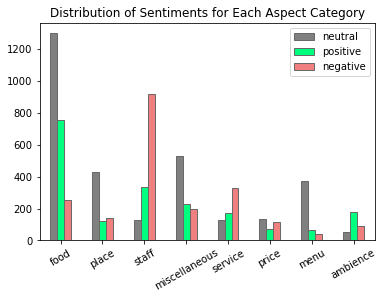

In [18]:
count_df.plot(kind = 'bar', color = ['grey', 'springgreen', 'lightcoral'], edgecolor = 'dimgrey')
plt.xticks(rotation = 30);
plt.title('Distribution of Sentiments for Each Aspect Category');

#### Insight: 
'menu' has hardly any meaningful reviews, so we can combine it with 'food'. 'ambience' & 'place', and 'staff' & 'service' are very similar topics which may be difficult for an LDA topic model to distinguish. Since 'ambience' and 'service' have relatively few occurrences, we will combine these very similar topics. 

Therefore, instead of the original 8 aspect categories from the MAMS paper, let's use 5:
- food (food+menu)
- service (service+staff)
- miscellaneous
- place (place+ambience) 
- price

# Naive Classifier:

In [19]:
#determine most common aspect category and sentiment in the corpus
naive_count = count_df.max().max()
print('Count of most frequent aspect category and sentiment combination: ', naive_count)

Count of most frequent aspect category and sentiment combination:  1298


In [20]:
#calculate accuracy of naive classifier that just assumes the most commonly occuring aspect category and sentiment combination
print(f'Accuracy of Naive Classifier: {round(naive_count / len(train_df) * 100, 5)} %')

Accuracy of Naive Classifier: 41.23253 %


# Text Cleaning & Pre-Processing:
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

## Tokenization:

In [21]:
def tokenize(text):
    """Creates tokens for LDA model. Passes over all whitespaces, adds special tokens for URLs and screen names. 
    Puts all tokens in lower case."""
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens 

In [22]:
test_parse = parser(train_df['text'][0])
type(test_parse)

spacy.tokens.doc.Doc

In [23]:
#See what happens at each step of the tokenize() function:
for token in test_parse[0:5]:
    print(token, '|', type(token), '|', token.orth_, '|', token.orth_.isspace(), '|', token.lower_)

It | <class 'spacy.tokens.token.Token'> | It | False | it
might | <class 'spacy.tokens.token.Token'> | might | False | might
be | <class 'spacy.tokens.token.Token'> | be | False | be
the | <class 'spacy.tokens.token.Token'> | the | False | the
best | <class 'spacy.tokens.token.Token'> | best | False | best


In [24]:
print(tokenize(train_df['text'][0]))

['it', 'might', 'be', 'the', 'best', 'sit', 'down', 'food', 'i', "'ve", 'had', 'in', 'the', 'area', ',', 'so', 'if', 'you', 'are', 'going', 'to', 'the', 'upright', 'citizen', 'brigade', ',', 'or', 'the', 'garden', ',', 'it', 'could', 'be', 'just', 'the', 'place', 'for', 'you', '.']


In [25]:
def get_lemma(word):
    """Lemmatize (get root word) for a given word."""
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [26]:
get_lemma('presented')

'present'

In [27]:
def get_lemma2(word):
    """More lemmatization."""
    return WordNetLemmatizer().lemmatize(word)

In [28]:
get_lemma2('feet')

'foot'

In [29]:
#download stopwords
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def prepare_text_for_lda(text):
    """Generate list of tokens, keeping all tokens that are >2 characters, and are not in the stopword list.
    Lemmatize each token."""
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2 and "'" not in token]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [31]:
print(f"BEFORE PRE-PROCESSING: {train_df['text'][0]} \n\nAFTER PRE-PROCESSING: {prepare_text_for_lda(train_df['text'][0])}")

BEFORE PRE-PROCESSING: It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you. 

AFTER PRE-PROCESSING: ['might', 'best', 'sit', 'food', 'area', 'going', 'upright', 'citizen', 'brigade', 'garden', 'could', 'place']


In [32]:
#pre-process all documents in the training set
text_data = []
for i in range(len(train_df)):
    tokens = prepare_text_for_lda(train_df['text'][i])
    text_data.append(tokens)

In [33]:
type(text_data), len(text_data), text_data[777]

(list,
 3148,
 ['food', 'awesome', 'deal', 'wait', 'staff', 'hardly', 'ever', 'find'])

## Bag-of-Words Representation:

In [34]:
#create a dictionary (vocabulary) of the corpus, and a bag-of-words representation of the corpus
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [32]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [35]:
type(dictionary), dictionary[0], dictionary[3], dictionary[7]

(gensim.corpora.dictionary.Dictionary, 'area', 'citizen', 'going')

In [36]:
type(corpus), len(corpus), len(corpus[0]), corpus[0][0], corpus[0][1], corpus[0][2], corpus[0][3], corpus[1][0], corpus[1][1]

(list, 3148, 12, (0, 1), (1, 1), (2, 1), (3, 1), (12, 1), (13, 1))

Note that the corpus variable is a list. Each element is a document, and within each document, the words are represented by tuples of *(token_id, token_count)*.

In [47]:
print('BoW Representation of Document 77 in corpus: \n', corpus[77])

BoW Representation of Document 77 in corpus: 
 [(40, 1), (49, 1), (130, 1), (153, 1), (279, 1), (484, 2), (485, 1), (486, 1), (487, 1)]


## TF-IDF Representation:

In [45]:
#use previously created corpus to create and fit TF-IDF representation
tfidf = TfidfModel(corpus)

In [53]:
tfidf_corpus = [tfidf[doc] for doc in corpus]

In [55]:
print('TF-IDF Representation of Document 77 in corpus: \n', tfidf_corpus[77])

TF-IDF Representation of Document 77 in corpus: 
 [(40, 0.16565435298419193), (49, 0.2049189573411614), (130, 0.10975058432370582), (153, 0.2653403073838501), (279, 0.22423402243831253), (484, 0.59450153024223), (485, 0.36913585009310146), (486, 0.26690997370612535), (487, 0.4867247791212905)]


# Topic Modelling with LDA:

In [41]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL
#training LDA model on BoW representation

NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes = 25)
ldamodel.save('model5.gensim')

In [56]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL
#training LDA model on TF-IDF representation

NUM_TOPICS = 5
ldamodel_tfidf = gensim.models.ldamodel.LdaModel(tfidf_corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes = 25)
ldamodel_tfidf.save('model5_tfidf.gensim')

In [57]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL
#print highest probability words for each topic
MODEL = ldamodel_tfidf

topics = MODEL.print_topics(num_words = 7)
for topic in topics:
    print(topic)

(0, '0.008*"waiter" + 0.008*"drink" + 0.008*"table" + 0.008*"food" + 0.008*"service" + 0.008*"get" + 0.008*"wait"')
(1, '0.004*"coming" + 0.003*"middle" + 0.003*"different" + 0.003*"question" + 0.002*"best" + 0.002*"pricey" + 0.002*"stay"')
(2, '0.007*"price" + 0.005*"portion" + 0.005*"hours" + 0.005*"food" + 0.005*"good" + 0.004*"expect" + 0.004*"menu"')
(3, '0.004*"red" + 0.004*"overall" + 0.003*"serve" + 0.003*"like" + 0.002*"inform" + 0.002*"special" + 0.002*"quick"')
(4, '0.007*"menu" + 0.004*"special" + 0.003*"dish" + 0.003*"food" + 0.003*"cool" + 0.003*"chicken" + 0.003*"fresh"')


In [58]:
#DON'T RUN IF YOU'RE NOT TRAINING A NEW MODEL
#test LDA model on new document
new_doc = "I've never had a bad meal here, friendly staff and fresh sushi!"
new_doc = prepare_text_for_lda(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(MODEL.get_document_topics(new_doc_bow))

[(29, 1), (84, 1), (121, 1), (141, 1), (238, 1), (301, 1), (522, 1)]
[(0, 0.726576), (1, 0.025276754), (2, 0.025294088), (3, 0.02501118), (4, 0.19784199)]


### Visualize Topic Model:

In [61]:
#START HERE IF YOU AREN'T TRAINING A NEW MODEL
#select which word representations you want to use ('bow' or 'tfidf')
REPRESENTATION = 'tfidf'

corpus = pickle.load(open('corpus.pkl', 'rb'))

if REPRESENTATION == 'tfidf':
    lda = gensim.models.ldamodel.LdaModel.load('model5_tfidf.gensim')
else:
    lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

## Apply Topic Model to Training Set:

In [119]:
#numerical mapping for topics in LDA model

if REPRESENTATION == 'tfidf':
    topic_map = {0: 'service', 1: 'place', 2: 'price', 3: 'miscellaneous', 4: 'food'}
else:
    topic_map = {0: 'food', 1: 'price', 2: 'service', 3: 'miscellaneous', 4: 'place'}

### Note to Self:
using the last topic map ({0: 'food', ...}) with the TF-IDF representation results in ~53% accuracy. But these topics don't really make much sense when you look at it in pyLDAvis...

In [120]:
#print topic probabilities for a select few documents
#note sum of all probabilities is 1 for each document

doc_topics = [lda.get_document_topics(doc) for doc in corpus]
print(doc_topics[0], '\n', doc_topics[30], '\n', doc_topics[777])

[(0, 0.5710142), (1, 0.3825823), (2, 0.0154712815), (3, 0.015467983), (4, 0.015464184)] 
 [(0, 0.6252814), (1, 0.1325306), (2, 0.018539144), (3, 0.018212263), (4, 0.20543666)] 
 [(0, 0.692158), (1, 0.022396566), (2, 0.022440638), (3, 0.022674631), (4, 0.24033016)]


In [121]:
#map topic numbers to topics
A = {topic_map[x[0]]:x[-1] for x in doc_topics[0]}
A

{'service': 0.5710142,
 'place': 0.3825823,
 'price': 0.0154712815,
 'miscellaneous': 0.015467983,
 'food': 0.015464184}

In [122]:
#get the 2 strongest topics for document A
newA = dict(sorted(A.items(), key = itemgetter(1), reverse = True)[:2])
newA

{'service': 0.5710142, 'place': 0.3825823}

In [123]:
def get_strong_topics(document, topic_map, topic_threshold):
    """Gets all the topics with probabilities greater than a threshold probability. If only 1 topic has a probability greater than the
    threshold, get the top 2 most probable topics.
    Returns dictionary of strongest topics."""
    
    topic_dict = {topic_map[topic[0]]: topic[1] for topic in document}
    output = {k:v for k,v in topic_dict.items() if v > topic_threshold}
    
    if len(output) == 1:
        output = dict(sorted(topic_dict.items(), key = itemgetter(1), reverse = True)[0:2])
    
    return output        

In [124]:
get_strong_topics(document = doc_topics[0], topic_map = topic_map, topic_threshold = 0.1)

{'service': 0.5710142, 'place': 0.3825823}

In [125]:
#for each document in training set, get strongest topics that exceed threshold (or top 2 topics if no topics exceed threshold)
TOPIC_THRESHOLD = 0.1

strong_topics = []
    
for doc in doc_topics:
    tmp = get_strong_topics(document = doc, topic_map = topic_map, topic_threshold = TOPIC_THRESHOLD)
    strong_topics.append(tmp)

strong_topics[0:3], len(strong_topics)

([{'service': 0.5710142, 'place': 0.3825823},
  {'service': 0.89993966, 'price': 0.025021873},
  {'service': 0.9382794, 'place': 0.015483668}],
 3148)

In [126]:
strong_topics[30]

{'service': 0.6252814, 'place': 0.1325306, 'food': 0.20543666}

In [127]:
#create dataframe showing strongest learned topics for each document in the training set
lda_df = pd.DataFrame({'text': train_df['text'], 'lda_topic': strong_topics})
lda_df

,text,lda_topic
0,It might be the best sit down food I've had in...,"{'service': 0.5710142, 'place': 0.3825823}"
1,Hostess was extremely accommodating when we ar...,"{'service': 0.89993966, 'price': 0.025021873}"
2,We were a couple of minutes late for our reser...,"{'service': 0.9382794, 'place': 0.015483668}"
3,"Though the service might be a little slow, the...","{'service': 0.89972734, 'price': 0.025125276}"
4,Although we arrived at the restaurant 10 min l...,"{'service': 0.89974165, 'price': 0.025130821}"
...,...,...
3143,We walked out the door with only a drink in ea...,"{'service': 0.8854838, 'food': 0.028660055}"
3144,"It took us 20 minutes to get a check, despite ...","{'service': 0.93829703, 'price': 0.015470957}"
3145,"The pancakes were good, but don't have blueber...","{'service': 0.19482328, 'price': 0.75489867}"
3146,"Our waiter disappeared entirely, our food, whe...","{'service': 0.8990595, 'place': 0.07470649}"


## Sentiment Analysis (NLTK VADER):

In [71]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [72]:
#test out VADER sentiment analyzer
sample2 = lda_df['text'][0]
print(sample2, '\n', sid.polarity_scores(sample2))

It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you. 
 {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.6369}


In [73]:
sample3 = "This was a bland and flavorless experience to say the least."
sid.polarity_scores(sample3)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [128]:
#perform sentiment analysis for each document
#assign sentiment to each learned aspect category for each document

lda_df['vader_score'] = lda_df['text'].apply(lambda review: sid.polarity_scores(review))
lda_df['compound_score'] = lda_df['vader_score'].apply(lambda score_dict: score_dict['compound'])
lda_df['sentiment'] = lda_df['compound_score'].apply(lambda sent: 'positive' if sent > 0 else ('neutral' if sent ==0 else 'negative'))

for cat in categories:
    lda_df[f'{cat}'] = lda_df['lda_topic'].apply(lambda x: encode_category(x, cat))
    lda_df[f'{cat}'] = lda_df[f'{cat}'].mask(lda_df[f'{cat}'].notnull(), lda_df['sentiment'])

lda_df.head()

,text,lda_topic,vader_score,compound_score,sentiment,food,place,staff,miscellaneous,service,price,menu,ambience
0,It might be the best sit down food I've had in...,"{'service': 0.5710142, 'place': 0.3825823}","{'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'comp...",0.6369,positive,NaN,positive,None,NaN,positive,NaN,None,None
1,Hostess was extremely accommodating when we ar...,"{'service': 0.89993966, 'price': 0.025021873}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,NaN,NaN,None,NaN,neutral,neutral,None,None
2,We were a couple of minutes late for our reser...,"{'service': 0.9382794, 'place': 0.015483668}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,NaN,neutral,None,NaN,neutral,NaN,None,None
3,"Though the service might be a little slow, the...","{'service': 0.89972734, 'price': 0.025125276}","{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'comp...",0.5413,positive,NaN,NaN,None,NaN,positive,positive,None,None
4,Although we arrived at the restaurant 10 min l...,"{'service': 0.89974165, 'price': 0.025130821}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,NaN,NaN,None,NaN,neutral,neutral,None,None


In [129]:
assert len(train_df) == len(lda_df)

## LDA + NLTK VADER Model Evaluation:

In [130]:
#collect aspect categories and sentiment labels for the training set
train_df_cats = train_df[categories]
train_df_cats.replace(to_replace = [None], value = 'N/A', inplace = True)
train_df_cats

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,food,place,staff,miscellaneous,service,price,menu,ambience
0,positive,neutral,N/A,N/A,N/A,N/A,N/A,N/A
1,N/A,N/A,positive,neutral,N/A,N/A,N/A,N/A
2,N/A,N/A,negative,neutral,N/A,N/A,N/A,N/A
3,N/A,N/A,positive,N/A,negative,N/A,N/A,N/A
4,N/A,N/A,negative,neutral,N/A,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
3143,neutral,N/A,N/A,N/A,N/A,negative,N/A,N/A
3144,N/A,N/A,negative,N/A,N/A,neutral,N/A,N/A
3145,negative,N/A,N/A,N/A,N/A,N/A,neutral,N/A
3146,neutral,N/A,negative,neutral,N/A,neutral,N/A,N/A


In [131]:
#collect learned aspect categories and sentiments for the training set
lda_df_cats = lda_df[categories]
lda_df_cats.replace(to_replace = [None], value = 'N/A', inplace = True)
lda_df_cats

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,food,place,staff,miscellaneous,service,price,menu,ambience
0,N/A,positive,N/A,N/A,positive,N/A,N/A,N/A
1,N/A,N/A,N/A,N/A,neutral,neutral,N/A,N/A
2,N/A,neutral,N/A,N/A,neutral,N/A,N/A,N/A
3,N/A,N/A,N/A,N/A,positive,positive,N/A,N/A
4,N/A,N/A,N/A,N/A,neutral,neutral,N/A,N/A
...,...,...,...,...,...,...,...,...
3143,neutral,N/A,N/A,N/A,neutral,N/A,N/A,N/A
3144,N/A,N/A,N/A,N/A,positive,positive,N/A,N/A
3145,N/A,N/A,N/A,N/A,positive,positive,N/A,N/A
3146,N/A,negative,N/A,N/A,negative,N/A,N/A,N/A


In [132]:
#compare learned aspect categories and sentiments with training labels
#0 - learned sentiment does not match label
#1 - learned sentiment matches label

diff_df = train_df_cats.eq(lda_df_cats).astype(int)
diff_df

,food,place,staff,miscellaneous,service,price,menu,ambience
0,0,0,1,1,0,1,1,1
1,1,1,0,0,0,0,1,1
2,1,0,0,0,0,1,1,1
3,1,1,0,1,0,0,1,1
4,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...
3143,1,1,1,1,0,0,1,1
3144,1,1,0,1,0,0,1,1
3145,0,1,1,1,0,0,0,1
3146,0,0,0,0,0,0,1,1


In [133]:
#only compare sentiments for learned LDA topics 
reduced_cats = ['food', 'place', 'service', 'price', 'miscellaneous']

In [134]:
#calculate classification accuracy for each aspect category
diff_df[reduced_cats].mean()

food             0.318297
place            0.628653
service          0.144536
price            0.674079
miscellaneous    0.582592
dtype: float64

In [135]:
#calculate mean classification accuracy across all aspect categories
diff_df[reduced_cats].mean().mean()

0.4696315120711563

# Sentiment Analysis (BERT):

In [82]:
bert_classifier = pipeline('sentiment-analysis')

In [83]:
bert_classifier('We are very happy to show you the 🤗 Transformers library.')

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [84]:
bert_classifier('It took us 20 minutes to get a check, despite many attempts at meaningful eye contact with the wait staff.')

[{'label': 'NEGATIVE', 'score': 0.999290406703949}]

In [113]:
bert_df = pd.DataFrame({'text': train_df['text'], 'lda_topic': strong_topics})

bert_df['sentiment'] = bert_df['text'].apply(lambda x: bert_classifier(x))

In [86]:
bert_df['sentiment'][0][0]

{'label': 'NEGATIVE', 'score': 0.865111231803894}

In [114]:
for cat in categories:
    bert_df[f'{cat}'] = bert_df['lda_topic'].apply(lambda x: encode_category(x, cat))
    bert_df[f'{cat}'] = bert_df[f'{cat}'].mask(bert_df[f'{cat}'].notnull(), bert_df['sentiment'][0][0]['label'].lower())

In [115]:
bert_df.head()

,text,lda_topic,sentiment,food,place,staff,miscellaneous,service,price,menu,ambience
0,It might be the best sit down food I've had in...,"{'service': 0.57103175, 'miscellaneous': 0.382...","[{'label': 'NEGATIVE', 'score': 0.865111231803...",NaN,NaN,None,negative,negative,NaN,None,None
1,Hostess was extremely accommodating when we ar...,"{'service': 0.89993864, 'price': 0.025022436}","[{'label': 'POSITIVE', 'score': 0.997357010841...",NaN,NaN,None,NaN,negative,negative,None,None
2,We were a couple of minutes late for our reser...,"{'service': 0.93827957, 'miscellaneous': 0.015...","[{'label': 'NEGATIVE', 'score': 0.999700009822...",NaN,NaN,None,negative,negative,NaN,None,None
3,"Though the service might be a little slow, the...","{'service': 0.8997272, 'price': 0.025125396}","[{'label': 'POSITIVE', 'score': 0.999799609184...",NaN,NaN,None,NaN,negative,negative,None,None
4,Although we arrived at the restaurant 10 min l...,"{'service': 0.8997417, 'price': 0.025130773}","[{'label': 'NEGATIVE', 'score': 0.999439239501...",NaN,NaN,None,NaN,negative,negative,None,None


# LDA + BERT Model Evaluation:

In [116]:
#collect learned aspect categories and sentiments for the training set
bert_df_cats = bert_df[categories]
bert_df_cats.replace(to_replace = [None], value = 'N/A', inplace = True)

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [117]:
#compare learned aspect categories and sentiments with training labels
#0 - learned sentiment does not match label
#1 - learned sentiment matches label

bert_diff_df = train_df_cats.eq(bert_df_cats).astype(int)
#calculate classification accuracy for each aspect category
bert_diff_df[reduced_cats].mean()

food             0.197268
place            0.624524
service          0.154701
price            0.681067
miscellaneous    0.556544
dtype: float64

In [118]:
#calculate mean classification accuracy across all aspect categories
bert_diff_df[reduced_cats].mean().mean()

0.4428208386277001

#### Bag-of-Word Representation:
LDA + NLTK accuracy was **~48%**, LDA + BERT accuracy is **~45%**. BERT is currently performing worse?

#### TF-IDF Representation:
LDA + NLTK accuracy was **~47%**, LDA + BERT accuracy is **~44%**. VADER still outperforms BERT?

# Identifying Sources of Error:
Is the LDA model, or is the sentiment analysis the major contributor to classification error?

In [136]:
def compare_topics(labels, learned_labels):
    """Returns percentage of learned labels that are also in the ground truth labels."""
    intersection = [label for label in learned_labels if label in labels]
    score = len(intersection) / len(labels)
    return score

In [137]:
compare_topics(list(train_df['sentiment'][0].keys()), list(lda_df['lda_topic'][0].keys()))

0.5

In [138]:
#Compare assigned topics from LDA model with training set labels
compared_topics = pd.concat([train_df['sentiment'], lda_df['lda_topic']], axis = 1)
compared_topics.columns = ['labels', 'learned_topics']
compared_topics['comparison'] = compared_topics.apply(lambda x: compare_topics(x['labels'], x['learned_topics']), axis = 1)
compared_topics

,labels,learned_topics,comparison
0,"{'food': 'positive', 'place': 'neutral'}","{'service': 0.5710142, 'place': 0.3825823}",0.5
1,"{'staff': 'positive', 'miscellaneous': 'neutral'}","{'service': 0.89993966, 'price': 0.025021873}",0.0
2,"{'miscellaneous': 'neutral', 'staff': 'negative'}","{'service': 0.9382794, 'place': 0.015483668}",0.0
3,"{'service': 'negative', 'staff': 'positive'}","{'service': 0.89972734, 'price': 0.025125276}",0.5
4,"{'staff': 'negative', 'miscellaneous': 'neutral'}","{'service': 0.89974165, 'price': 0.025130821}",0.0
...,...,...,...
3143,"{'food': 'neutral', 'price': 'negative'}","{'service': 0.8854838, 'food': 0.028660055}",0.5
3144,"{'price': 'neutral', 'staff': 'negative'}","{'service': 0.93829703, 'price': 0.015470957}",0.5
3145,"{'food': 'negative', 'menu': 'neutral'}","{'service': 0.19482328, 'price': 0.75489867}",0.0
3146,"{'staff': 'negative', 'food': 'neutral', 'misc...","{'service': 0.8990595, 'place': 0.07470649}",0.0


In [139]:
compared_topics['comparison'].mean()

0.3077191867852614

Using BoW, LDA classified **~33%** of topics correctly.

Using TF-IDF, LDA classified **~31%** of topics correctly.